## Problem definition

The problem is predicting who has diabetes based on health and lifestyle factors. By looking at data like age, BMI, and blood pressure, we aim to find people at risk for diabetes. This can help doctors catch it early and provide better care.

# Data Preparation and Exploratory Analysis

In [37]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, validation_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.linear_model import LogisticRegression

In [38]:
# Read the diabetes data from a CSV file
diabetes_data = pd.read_csv('diabetes.csv')

# Show the first few rows and the column names
print(diabetes_data.head())
print(diabetes_data.columns)

   Age  Gender  BMI Blood Pressure  FBS  HbA1c Family History of Diabetes  \
0   45    Male   25         Normal  100    5.7                         No   
1   55  Female   30           High  120    6.4                        Yes   
2   65    Male   35           High  140    7.1                        Yes   
3   75  Female   40           High  160    7.8                        Yes   
4   40    Male   20         Normal   80    5.0                         No   

  Smoking     Diet Exercise Diagnosis  
0      No  Healthy  Regular        No  
1     Yes     Poor       No       Yes  
2     Yes     Poor       No       Yes  
3     Yes     Poor       No       Yes  
4      No  Healthy  Regular        No  
Index(['Age', 'Gender', 'BMI', 'Blood Pressure', 'FBS', 'HbA1c',
       'Family History of Diabetes', 'Smoking', 'Diet', 'Exercise',
       'Diagnosis'],
      dtype='object')


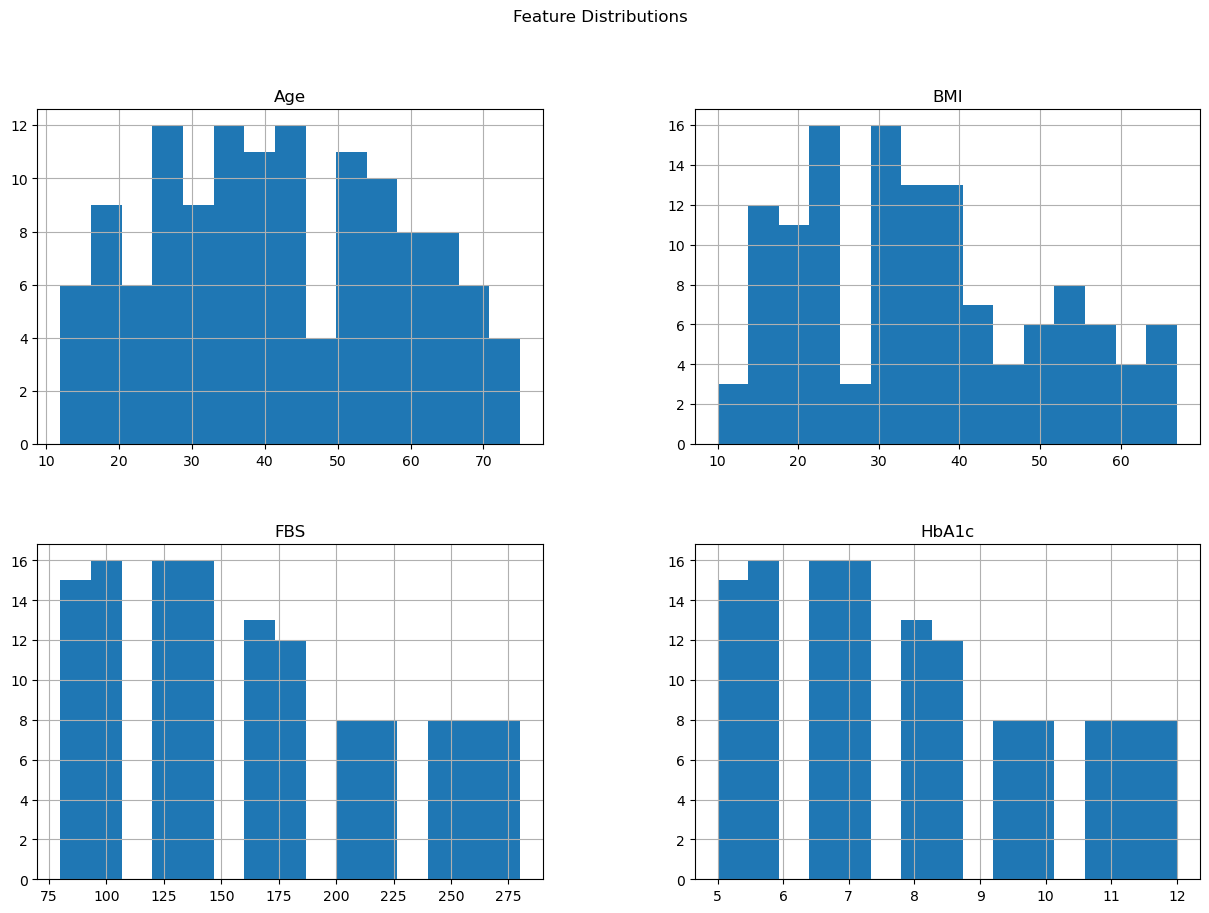

In [39]:
# Display histograms to see the distribution of each feature
diabetes_data.hist(bins=15, figsize=(15, 10))
plt.suptitle('Feature Distributions')
plt.show()


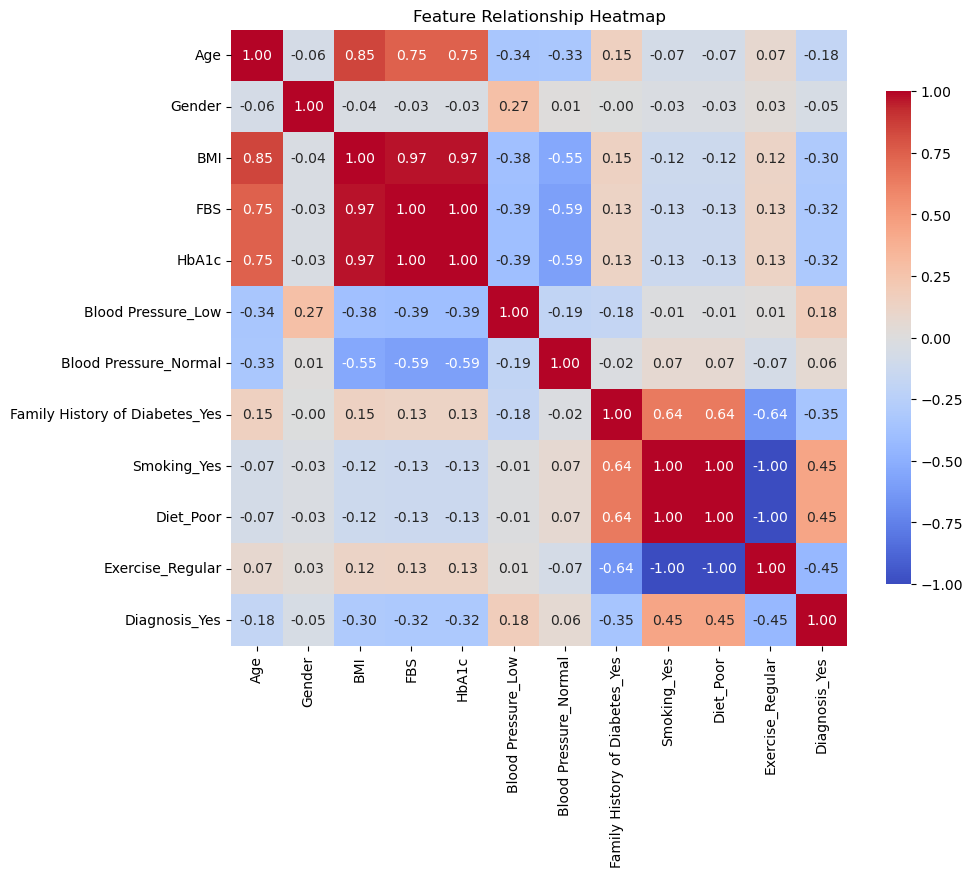

In [40]:
# Convert 'Gender' column to numerical values
diabetes_data['Gender'] = diabetes_data['Gender'].map({'Male': 1, 'Female': 0})

# Convert other categorical variables to numerical values
diabetes_data = pd.get_dummies(diabetes_data, drop_first=True)

# Plot Feature Relationship Heatmap
plt.figure(figsize=(10, 8))
correlation_matrix = diabetes_data.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Feature Relationship Heatmap') # Title for the heatmap
plt.show()

In [41]:
print(diabetes_data.columns) # Display the updated columns

# Define features and the target variable (Diagnosis)
X = diabetes_data[['Age', 'Gender', 'BMI', 'FBS', 'HbA1c', 'Blood Pressure_Low', 'Blood Pressure_Normal', 'Family History of Diabetes_Yes', 'Smoking_Yes', 'Diet_Poor', 'Exercise_Regular', 'Diagnosis_Yes']]
y = diabetes_data['Diagnosis_Yes'] # Diagnosis column

# Convert categorical features to numbers
X = pd.get_dummies(X, drop_first=True)  # Avoids creating too many columns

# Scale features to have a mean of 0 and a standard deviation of 1
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) # Fit the scaler and transform the data

Index(['Age', 'Gender', 'BMI', 'FBS', 'HbA1c', 'Blood Pressure_Low',
       'Blood Pressure_Normal', 'Family History of Diabetes_Yes',
       'Smoking_Yes', 'Diet_Poor', 'Exercise_Regular', 'Diagnosis_Yes'],
      dtype='object')


In [42]:
# Split the data into training (75%) and testing (25%) sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=0)

# Print the shapes of the training and testing sets
print("X_train shape: {}".format(X_train.shape)) 
print("y_train shape: {}".format(y_train.shape))
print("X_test shape: {}".format(X_test.shape)) 
print("y_test shape: {}".format(y_test.shape))

X_train shape: (96, 12)
y_train shape: (96,)
X_test shape: (32, 12)
y_test shape: (32,)


# K-Nearest Neighbors (KNN) Classifier

In [43]:
# Set a range of 'k' values (number of neighbors) to test
k_range = list(range(1, 50))

# Check how well the KNN classifier performs with different 'k' values
train_score, test_score = validation_curve(
    KNeighborsClassifier(),
    X_train,
    y_train,
    param_name="n_neighbors",
    param_range=k_range,
    cv=5,  # Use 5-fold cross-validation
    scoring="accuracy"  # Measure accuracy
)

# Calculate the average scores for each 'k'
mean_train_score = np.mean(train_score, axis=1)
mean_test_score = np.mean(test_score, axis=1)

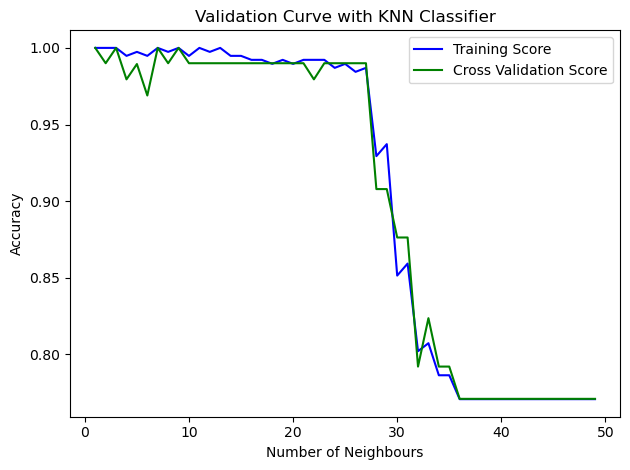

In [44]:
# Show how the number of neighbors affects accuracy
plt.plot(k_range, mean_train_score, label="Training Score", color='b')
plt.plot(k_range, mean_test_score, label="Cross Validation Score", color='g')
plt.title("Validation Curve with KNN Classifier")  # Title for the plot
plt.xlabel("Number of Neighbours")  # Label for x-axis
plt.ylabel("Accuracy")  # Label for y-axis
plt.tight_layout()
plt.legend(loc='best')  # Add a legend
plt.show()

In [45]:
# Choose an optimal number of neighbors (e.g., 11)
model = KNeighborsClassifier(n_neighbors=11)

# Train the KNN model with the training data
model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=11)

In [46]:
y_predicted = model.predict(X_test)

# Check how many predictions were correct
number_of_correct_predictions = (y_predicted == y_test).sum()  # Count correct predictions
number_of_predictions = len(y_predicted)  # Total predictions
percentage_correct = round(number_of_correct_predictions / number_of_predictions, 4)  # Calculate accuracy

In [47]:
print(f"{number_of_correct_predictions}/{number_of_predictions} ({percentage_correct}) of predictions are correct")

32/32 (1.0) of predictions are correct


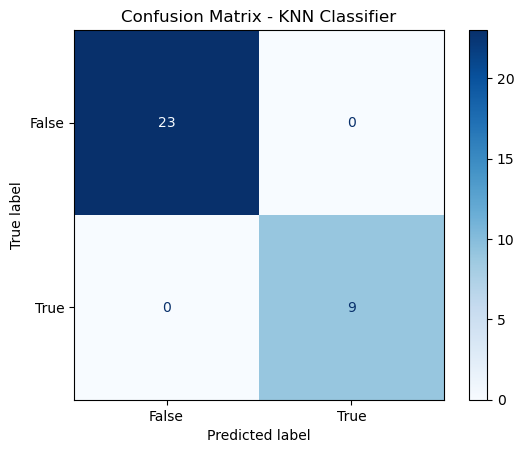

In [48]:
conf_matrix = confusion_matrix(y_test, y_predicted)
cmd = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=model.classes_)
cmd.plot(cmap='Blues')
plt.title('Confusion Matrix - KNN Classifier')  # Title for the confusion matrix
plt.show()

In [49]:
y_scores = model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class
fpr, tpr, thresholds = roc_curve(y_test, y_scores)  # Calculate false positive and true positive rates
roc_auc = auc(fpr, tpr)  # Calculate the area under the ROC curve

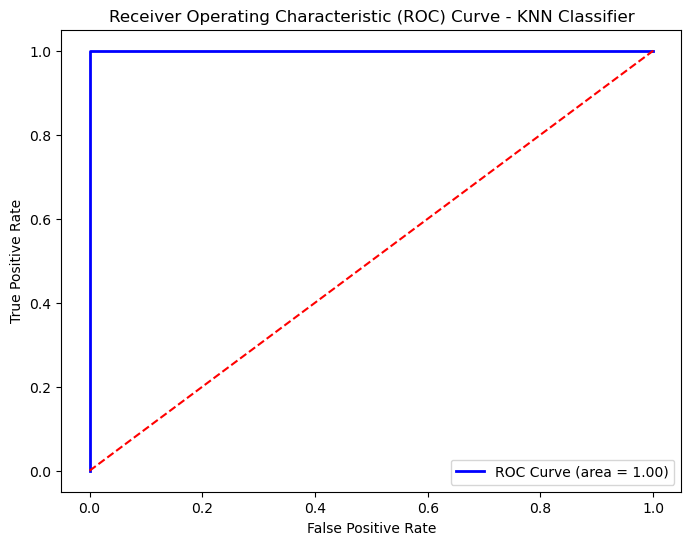

In [50]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC Curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line for reference
plt.title('Receiver Operating Characteristic (ROC) Curve - KNN Classifier')  # Title for the ROC curve
plt.xlabel('False Positive Rate')  # Label for x-axis
plt.ylabel('True Positive Rate')  # Label for y-axis
plt.legend(loc='best')  # Add a legend
plt.show()

# Logistic Regression

In [51]:
# Initialize the Logistic Regression model
logistic_model = LogisticRegression()

In [52]:
# Train the model with the training data
logistic_model.fit(X_train, y_train)

LogisticRegression()

In [53]:
# Make predictions on the test set
y_pred_logistic = logistic_model.predict(X_test)

32/32 (1.0) of predictions are correct with Logistic Regression


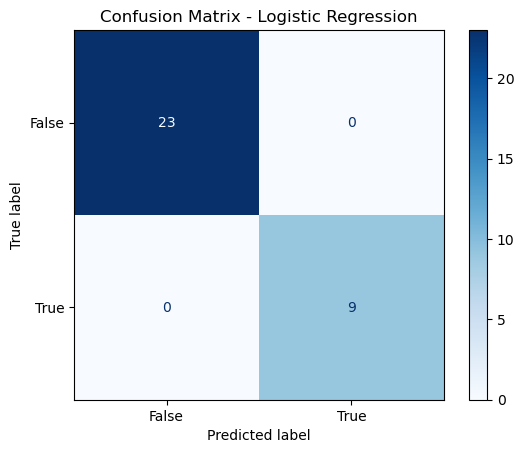

In [54]:
# Check how many predictions were correct
number_of_correct_predictions_logistic = (y_pred_logistic == y_test).sum()
number_of_predictions_logistic = len(y_pred_logistic)
percentage_correct_logistic = round(number_of_correct_predictions_logistic / number_of_predictions_logistic, 4)

print(f"{number_of_correct_predictions_logistic}/{number_of_predictions_logistic} ({percentage_correct_logistic}) of predictions are correct with Logistic Regression")

# Display confusion matrix for Logistic Regression
conf_matrix_logistic = confusion_matrix(y_test, y_pred_logistic)
cmd_logistic = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_logistic, display_labels=logistic_model.classes_)
cmd_logistic.plot(cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

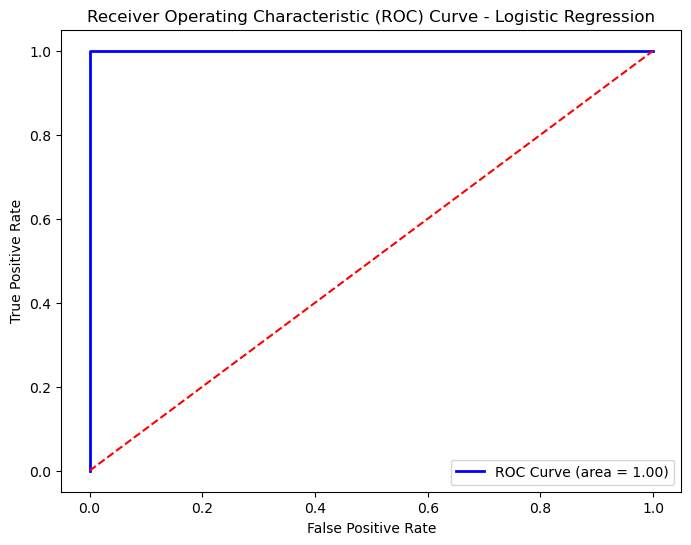

In [55]:
# Calculate ROC Curve and AUC for Logistic Regression
y_scores_logistic = logistic_model.predict_proba(X_test)[:, 1]
fpr_logistic, tpr_logistic, thresholds_logistic = roc_curve(y_test, y_scores_logistic)
roc_auc_logistic = auc(fpr_logistic, tpr_logistic)

plt.figure(figsize=(8, 6))
plt.plot(fpr_logistic, tpr_logistic, color='blue', lw=2, label='ROC Curve (area = {:.2f})'.format(roc_auc_logistic))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve - Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.show()